In [1]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [1]:
%matplotlib inline
import sys
sys.path.append('../')

import os
import json
import re
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# from fuzzywuzzy import fuzz, process
import textdistance

import nltk
from nltk.corpus import stopwords

import multiprocessing
import signal
import time

from parallel_task_handler import ParallelTaskHandler

In [2]:
# Increase the size of the matplotlib figures
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (24, 24)

In [3]:
def get_containing_folder():
    parent_folder = globals().get('_dh')
    if parent_folder is None:
        # This function is being run in a python file
        parent_folder = os.path.dirname(__file__)
    else:
        # This function is being run in a jupyter notebook
        parent_folder = parent_folder[0]
    
    return parent_folder

## Cleaning list of majors

In [4]:
PARENT_DIR = get_containing_folder()
EXTRACTED_JSON_PATH = f'{PARENT_DIR}/../json-dump/extracted'
os.makedirs(EXTRACTED_JSON_PATH, exist_ok=True)

ALL_RAW_MAJORS_PATH = f'{EXTRACTED_JSON_PATH}/all-majors.json'
ALL_CLEANED_MAJORS_PATH = f'{EXTRACTED_JSON_PATH}/all-majors-cleaned.json'

In [5]:
with open(ALL_RAW_MAJORS_PATH, 'r') as fp:
    all_majors = json.load(fp)

In [6]:
print('Number of all majors found:', len(all_majors))
unique_majors = sorted(list(set(all_majors)))
print('Number of unique majors found (before filtering):', len(unique_majors))

Number of all majors found: 4719801
Number of unique majors found (before filtering): 3296


In [ ]:
import string
import collections

import nltk
import contractions

from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from pprint import pprint

start_invalid = ('-', '=', '>', 'zzz', 'See ', 'Advising')
# print(stopwords.words('english'))

blacklist = (
    'Rady School of Management',
    'Bachelor of Arts',
    'Bachelor of Fine Arts',
    'Bachelor of Science',
    'Bachelor of Music',
    'BMus',
    'Bachelor',
    'Practice Of',
    'Option',
    'Concentration',
    'Emphasis',
    'Division',
    'Lower',
    'Requirements',
    'Specialization',
    'Major',
    'Minor',
    'Pre-Graduate',
    'Graduate',
    'Master',
    'School',
    'Track',
    'Undeclared',
    'Advanced',
    'Specialty',
    'Study Plan',
    'Study',
    'Combined',
)

accepted_accronyms = (
    '3-D', 'CSE', 'ACS', 'CIS', 'ECE', 'BCLAD',
    'MAE', 'UGA', 'ESPM', 'PETE', 'STEP', 'ICAM',
    'PACE', 'STEM', 'ENG'
)

# https://stackoverflow.com/a/3663505
def rchop(s, ending):
    if s.endswith(ending):
        return s[:-len(ending)]
    return s

def remove_dup_words(s):
    words = s.split()
    return ' '.join(sorted(set(words), key=words.index))

def better_process_text(major):
    major = re.sub("'s", '', major)
    
    srch = re.search(r'(\w+)-(\w+)', major)
    if srch:
        first = srch.group(1)
        second = srch.group(2)
        if first not in ['Pre', 'Bi'] and len(first) > 1:
            major = re.sub(r'(\w+)-(\w+)', f'{first} {second}', major)
    
    major = re.sub(r'\b,\b', ', ', major)

    major = re.sub(r'[A-Z]{1}\.', '', major)
    major = re.sub(r'\b[BRN][A-Z]{1,2}\b', '', major)
            
    major = re.sub(r"[^A-Za-z0-9 /().'&-]", '', major)
    major = re.sub(r'\W-\W', ' ', major)
    major = re.sub('&', 'and', major)
    major = re.sub('Mgt', 'Management', major)
    major = re.sub('Mg', 'Management', major)
    major = re.sub('Mgmt', 'Management', major)

    for word in blacklist:
        major = re.sub(word, '', major).strip()
        
    major = ' '.join([word for word in major.split(' ') if word.lower() not in stopwords.words("english")])
    
    major = re.sub(r'\(\)', '', major)
    major = re.sub(r'\s+', ' ', major).strip()
    major = rchop(major, ' and').strip()
    major = rchop(major, ' or').strip()
    major = rchop(major, '/S').strip()
    major = rchop(major, ' S').strip()
    major = rchop(major, '/').strip()
    major = rchop(major, '.').strip()
    major = re.sub('[()/]', ' ', major).strip()
    
    filtered_words = []
    for word in major.split():
        if word.isupper():
            if word.startswith('(') and word.endswith(')'):
                word = word[1:len(word)-1]
                
            if word in accepted_accronyms:
                filtered_words += [word]
            elif len(word) > 3 or word == 'ART' or word == 'AND':
                filtered_words += [word.title()]
        elif word.islower():
            filtered_words += [word.title()]
        else:
            
            if not word.istitle():
                print('ALERT', word)
            filtered_words += [word.title()]
    major = ' '.join(filtered_words)
    
    major = re.sub(r'\( ', '(', major)
    major = re.sub(r' \)', ')', major)
    
    major = re.sub(r'\(In\)', '', major)
    major = re.sub(r'\(A\)', '', major)
    major = re.sub(r'\(/\)', '', major)
    major = re.sub(r'\b(I+V?|V)\b', ' ', major)
    major = re.sub(r'\s+', ' ', major).strip()
    
    major = remove_dup_words(major)
    
    major = ' '.join([word for word in major.split(' ') if word.lower() not in stopwords.words("english")])
    
    if not False:
        for word in major.split():
            if word.isupper():
                print(word, '\t\t\t', major)
                
#     if 'Bachelor' in major:
#         print(orig)
#         print('  ', major)
    
    if '- ' in major:
        major = re.sub('- ', ' ', major)
        
    if ' -' in major:
        major = re.sub(' -', ' ', major)
    
    return major

def process_text(text):
    """ Tokenize text and stem words removing punctuation """
    text = re.sub(fr'[{string.punctuation}]', ' ', text)
    tokens = word_tokenize(text)
    return tokens

def cluster_texts(texts, clusters=3):
    """ Transform texts to Tf-Idf coordinates and cluster texts using K-Means """
    vectorizer = TfidfVectorizer(tokenizer=None,
                                 stop_words=stopwords.words('english'),
                                 max_df=1.0,
                                 min_df=0.0,
                                 ngram_range=(1,3),
                                 lowercase=True)
 
    tfidf_model = vectorizer.fit_transform(texts)
    print(np.min(tfidf_model), np.mean(tfidf_model), np.max(tfidf_model))
    km_model = KMeans(n_clusters=clusters, init='k-means++')
    km_model.fit(tfidf_model)
    
    print('Error:', km_model.inertia_)
 
    clustering = collections.defaultdict(list)
 
    for idx, label in enumerate(km_model.labels_):
        clustering[label].append(texts[idx])
    
    for label in km_model.labels_:
        if len(clustering[label]) == 1:
            print('HALP')
            print(label)
            print()

    return clustering

# filtered_unique_majors = [major for major in unique_majors if not major.startswith(start_invalid)]
print(len(truly_unique_majors))
clusters = cluster_texts(truly_unique_majors, len(truly_unique_majors) // 15)
pprint(dict(clusters))

In [7]:
with open('raw-majors.txt', 'w') as fp:
    fp.write('\n'.join(unique_majors).strip())

In [23]:
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans

wnl = nltk.WordNetLemmatizer()


start_invalid = ('-', '=', '>', 'zzz', 'See ', 'Advising')

blacklist = (
    'Rady School of Management',
    'Bachelor of Arts',
    'Bachelor of Fine Arts',
    'Bachelor of Science',
    'Bachelor of Music',
    'BMus',
    'Bachelor',
    'Practice Of',
    'Option',
    'Concentration',
    'Emphasis',
    'Division',
    'Lower',
    'Requirements',
    'Specialization',
    'Major',
    'Minor',
    'Pre-Graduate',
    'Graduate',
    'Master',
    'School',
    'Track',
    'Undeclared',
    'Advanced',
    'Specialty',
    'Study Plan',
    'Study',
    'Combined',
)

accepted_accronyms = (
    '3-D', 'CSE', 'ACS', 'CIS', 'ECE', 'BCLAD',
    'MAE', 'UGA', 'ESPM', 'PETE', 'STEP', 'ICAM',
    'PACE', 'STEM', 'ENG'
)

# https://stackoverflow.com/a/3663505
def rchop(s, ending):
    if s.endswith(ending):
        return s[:-len(ending)]
    return s

def remove_dup_words(s):
    words = s.split()
    return ' '.join(sorted(set(words), key=words.index))


truly_unique_majors = []

for major in unique_majors:
    orig = major
    if major.startswith(start_invalid):
        continue
        
    major = re.sub(r'\s+', ' ', major).strip()
        
#     major = re.sub("'s", '', major)
    
#     srch = re.search(r'(\w+)-(\w+)', major)
#     if srch:
#         first = srch.group(1)
#         second = srch.group(2)
#         if first not in ['Pre', 'Bi'] and len(first) > 1:
#             major = re.sub(r'(\w+)-(\w+)', f'{first} {second}', major)
    
#     major = re.sub(r'\b,\b', ', ', major)

#     major = re.sub(r'[A-Z]{1}\.', '', major)
#     major = re.sub(r'\b[BRN][A-Z]{1,2}\b', '', major)
            
#     major = re.sub(r"[^A-Za-z0-9 /().'&-]", '', major)
#     major = re.sub(r'\W-\W', ' ', major)
#     major = re.sub('&', 'and', major)
#     major = re.sub('Mgt', 'Management', major)
#     major = re.sub('Mg', 'Management', major)
#     major = re.sub('Mgmt', 'Management', major)

#     for word in blacklist:
#         major = re.sub(word, '', major).strip()
        
#     major = ' '.join([word for word in major.split(' ') if word.lower() not in stopwords.words("english")])
    
#     major = re.sub(r'\(\)', '', major)
#     major = re.sub(r'\s+', ' ', major).strip()
#     major = rchop(major, ' and').strip()
#     major = rchop(major, ' or').strip()
#     major = rchop(major, '/S').strip()
#     major = rchop(major, ' S').strip()
#     major = rchop(major, '/').strip()
#     major = rchop(major, '.').strip()
#     major = re.sub('[()/]', ' ', major).strip()
    
#     filtered_words = []
#     for word in major.split():
#         if word.isupper():
#             if word.startswith('(') and word.endswith(')'):
#                 word = word[1:len(word)-1]
                
#             if word in accepted_accronyms:
#                 filtered_words += [word]
#             elif len(word) > 3 or word == 'ART' or word == 'AND':
#                 filtered_words += [word.title()]
#         elif word.islower():
#             filtered_words += [word.title()]
#         else:
            
#             if not word.istitle():
#                 print('ALERT', word)
#             filtered_words += [word.title()]
#     major = ' '.join(filtered_words)
    
#     major = re.sub(r'\( ', '(', major)
#     major = re.sub(r' \)', ')', major)
    
#     major = re.sub(r'\(In\)', '', major)
#     major = re.sub(r'\(A\)', '', major)
#     major = re.sub(r'\(/\)', '', major)
#     major = re.sub(r'\b(I+V?|V)\b', ' ', major)
#     major = re.sub(r'\s+', ' ', major).strip()
    
#     major = remove_dup_words(major)
    
#     major = ' '.join([word for word in major.split(' ') if word.lower() not in stopwords.words("english")])
    
#     if not False:
#         for word in major.split():
#             if word.isupper():
#                 print(word, '\t\t\t', major)
                
#     if 'Bachelor' in major:
#         print(orig)
#         print('  ', major)
    
#     if '- ' in major:
#         major = re.sub('- ', ' ', major)
        
#     if ' -' in major:
#         major = re.sub(' -', ' ', major)

    tokens = word_tokenize(major)
    tokens = [wnl.lemmatize(t.lower()) for t in tokens]
    for t in tokens:
        
    tokens = [t for t in tokens if t not in ')']
    print(tokens)
#     text = nltk.Text(tokens)
#     test = text.concordance('mechatronic')
#     print(test)

    if major:
        truly_unique_majors += []

truly_unique_majors = sorted(truly_unique_majors)
# truly_unique_majors = sorted(list(set(truly_unique_majors)))
print('Number of unique majors found (after filtering):', len(truly_unique_majors))
pprint(truly_unique_majors)

['accountancy', ',', 'b.s', '.', '-', 'option', 'in', 'information', 'system']
['accountancy', ',', 'b.s', '.', '-', 'option', 'in', 'professional', 'accountancy']
['africana', 'study', ',', 'b.a', '.', '-', 'option', 'in', 'african', 'and', 'african-american', 'humanity', 'and', 'cultural', 'study']
['africana', 'study', ',', 'b.a', '.', '-', 'option', 'in', 'african', 'and', 'african-american', 'social', 'science']
['africana', 'study', ',', 'b.a', '.', '-', 'option', 'in', 'african-american', 'urban', 'education']
['anthropology', ',', 'b.a', '.']
['art', ',', 'b.a', '.']
['asian', 'american', 'study', ',', 'b.a', '.']
['athletic', 'training', ',', 'b.s', '.']
['accountancy']
['accounting', '(', 'minor', 'in']
['accounting', '-', 'b']
['accounting', 'minor', ':', 'rady', 'school', 'of', 'management']
['actuarial', 'science', ',', 'b.s', '.']
['administration']
['administration', '-', 'b.a', '.']
['administration', '-', 'b.s', '.']
['aerospace', 'engineering/b.s']
['aerospace', 'engi

['cinema', 'and', 'television', 'art', ',', 'b.a', '.', '-', 'option', 'in', 'electronic', 'medium', 'management']
['cinema', 'and', 'television', 'art', ',', 'b.a', '.', '-', 'option', 'in', 'entertainment', 'medium', 'management']
['cinema', 'and', 'television', 'art', ',', 'b.a', '.', '-', 'option', 'in', 'film', 'production']
['cinema', 'and', 'television', 'art', ',', 'b.a', '.', '-', 'option', 'in', 'medium', 'theory', 'and', 'criticism']
['cinema', 'and', 'television', 'art', ',', 'b.a', '.', '-', 'option', 'in', 'multimedia', 'production']
['cinema', 'and', 'television', 'art', ',', 'b.a', '.', '-', 'option', 'in', 'screenwriting']
['cinema', 'and', 'television', 'art', ',', 'b.a', '.', '-', 'option', 'in', 'television', 'production']
['civil', 'engineering', ',', 'b.s', '.']
['communication', 'disorder', ',', 'b.a', '.']
['communication', 'study', ',', 'b.a', '.']
['computer', 'engineering', ',', 'b.s', '.']
['computer', 'information', 'technology', ',', 'b.s', '.']
['computer

['education', 'science', ',', 'b.a', '.']
['education', ',', 'minor']
['educational', 'study', '(', 'minor', 'in']
['electrical', 'engineering']
['electrical', 'engineering', '&', 'computer', 'sci/materials', 'sci', '&', 'engin', ',', 'lower', 'division', 'b.s', '.']
['electrical', 'engineering', '&', 'computer', 'sci/nuclear', 'engineering', ',', 'lower', 'division', 'b.s', '.']
['electrical', 'engineering', '&', 'computer', 'science', ',', 'lower', 'division', 'b.s', '.']
['electrical', 'engineering', '(', 'b.s', '.']
['electrical', 'engineering', '-', 'b']
['electrical', 'engineering', 'b.s', '.']
['electrical', 'engineering', ',', 'b.a', '.']
['electrical', 'engineering', ',', 'b.s', '.']
['electrical', 'engineering/b.s', '.']
['electrical/electronic', 'engineering', 'b.s', '.']
['electromechanical', 'system', 'engineering', 'technology', 'b.s', '.']
['electromechanical', 'system', 'engineering', 'technology', ',', 'b.s', '.']
['electronic', 'material', 'engineering', 'b.s', '.']
[

['industrial', 'art', '-', 'graphic', 'design', 'option']
['industrial', 'art', ',', 'b.a', '.']
['industrial', 'design']
['industrial', 'design', ',', 'b.s', '.']
['industrial', 'design', ':', 'concentration', 'in', 'product', 'design', 'and', 'development', ',', 'b.s', '.']
['industrial', 'engineering', '&', 'operation', 'research', ',', 'lower', 'division', 'b.s', '.']
['industrial', 'engineering', '(', 'b.s', '.']
['industrial', 'engineering', 'b.s', '.']
['industrial', 'engineering', ',', 'b.s', '.']
['industrial', 'technology']
['industrial', 'technology', '(', 'b.s', '.']
['industrial', 'technology', '-', 'agricultural', 'system', 'management', 'option', '(', 'b.s', '.']
['industrial', 'technology', '-', 'b']
['industrial', 'technology', '-', 'cad/cam', 'system', 'management', 'specialty']
['industrial', 'technology', '-', 'computer-aided', 'manufacturing', 'mgt', 'specialty']
['industrial', 'technology', '-', 'education']
['industrial', 'technology', '-', 'graphic', 'communicat

['native', 'american', 'study', '-', 'law', '&', 'government']
['native', 'american', 'study', '-', 'society', '&', 'culture']
['native', 'american', 'study', 'a.b', '.']
['native', 'american', 'study', 'b.a', '.']
['native', 'american', 'study', ',', 'b.a', '.']
['native', 'american', 'study', ',', 'lower', 'division', 'b.a', '.']
['natural', 'resource', 'planning']
['natural', 'resource', 'planning', 'and', 'interpretation']
['natural', 'science', '-', 'b']
['natural', 'science']
['natural', 'science', '-', 'biology', 'option', '(', 'b.a', '.']
['natural', 'science', '-', 'chemistry', 'option', '(', 'b.a', '.']
['natural', 'science', '-', 'earth', 'science', 'option', '(', 'b.a', '.']
['natural', 'science', '-', 'physic', 'option', '(', 'b.a', '.']
['natural', 'science', 'b.a', '.', '-', 'chemistry', 'option']
['natural', 'science', 'b.a', '.', '-', 'environmental', 'science', 'option']
['natural', 'science', 'b.a', '.', '-', 'general', 'biology', 'option']
['natural', 'science', 'b.

['viticulture', 'and', 'enology', 'b.s', '.']
['wildlife']
['wildlife', '-', 'conservation', 'biology/applied', 'vertebrate', 'ecology']
['wildlife', '-', 'wildlife', 'management', '&', 'conservation']
['wildlife', 'b.s', '.', '-', 'conservation', 'biology/applied', 'vertebrate', 'ecology', 'concentration']
['wildlife', 'b.s', '.', '-', 'wildlife', 'management', '&', 'conservation', 'concentration']
['wildlife', ',', 'fish', 'and', 'conservation', 'biology', 'b.s', '.']
['wine', '&', 'viticulture', ',', 'b.s', '.']
['wine', 'and', 'viticulture', ',', 'b.s', '.']
['woman', 'and', 'gender', 'study']
['woman', 'and', 'gender', 'study', ',', 'b.a', '.']
['woman', "'s", 'study']
['woman', "'s", 'study']
['woman', "'s", 'study', '(', 'b.a', '.']
['woman', "'s", 'study', 'b.a', '.']
['woman', "'s", ',', 'gender', ',', 'and', 'sexuality', 'study']
['woman', "'s", ',', 'gender', ',', 'and', 'sexuality', 'study', '-', 'ba']
['worksheet', 'uga', '(', 'eng']
['world', 'art', 'and', 'cultures/b.a',

In [219]:
with open(ALL_CLEANED_MAJORS_PATH, 'w') as fp:
    json.dump(truly_unique_majors, fp, indent=4)

# Finding most common words

In [220]:
with open(ALL_CLEANED_MAJORS_PATH, 'r') as fp:
    all_cleaned_majors = json.load(fp)

In [221]:
all_words = (' '.join(all_cleaned_majors)).split()
print('Number of words (before filtering):', len(all_words))

all_words_0th_pass = [re.sub(r'[(),/-]', ' ', word) for word in all_words]
all_words_0th_pass = [re.sub(r'\s+', ' ', word).strip().split(' ') for word in all_words_0th_pass]
all_words_0th_pass = [word for phrase in all_words_0th_pass for word in phrase]

all_words_1st_pass = [word for word in all_words_0th_pass if len(word) > 2 and word.lower() not in stopwords.words("english")]
print('Number of words (after filtering):', len(all_words_1st_pass))

counter = Counter(all_words_1st_pass)
most_common = counter.most_common()
print('Number of unique words:', len(most_common))

Number of words (before filtering): 6649
Number of words (after filtering): 6680
Number of unique words: 827


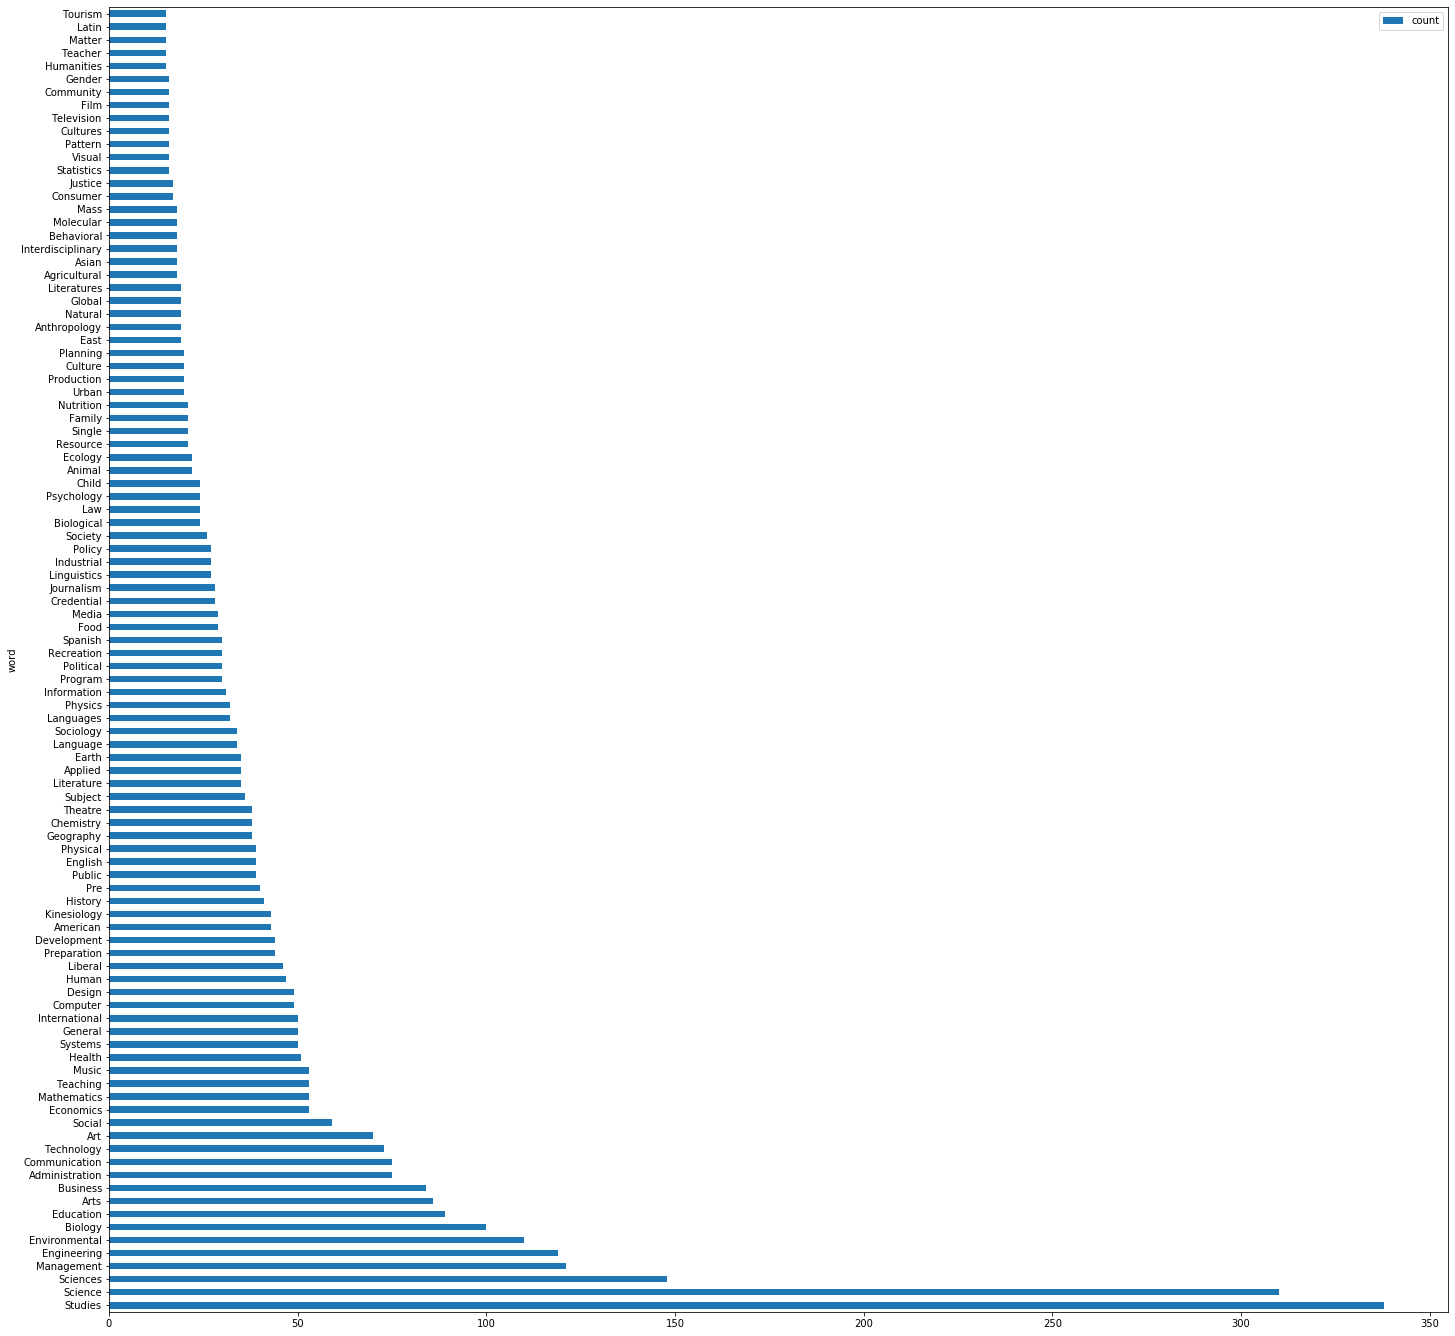

In [222]:
df_words = pd.DataFrame(most_common[::][:100], columns=['word', 'count'])
df_words.plot.barh(y='count', x='word')

## Finding similarities between majors

In [223]:
subset = all_cleaned_majors
print('Number of majors in subset (before filtering):', len(subset))

subset = list(set(subset))
print('Number of majors in subset (after filtering):', len(subset))

Number of majors in subset (before filtering): 2047
Number of majors in subset (after filtering): 2047


In [76]:
with open('princeton-review-majors.txt', 'r') as fp:
    review_majors = fp.readlines()
review_majors = [major.strip() for major in review_majors]

In [77]:
pprint(review_majors)

['Accounting',
 'Actuarial Science',
 'Advertising',
 'Aerospace Engineering',
 'African Languages, Literatures, and Linguistics',
 'African Studies',
 'African-American Studies',
 'Agricultural Business and Management',
 'Agricultural Economics',
 'Agricultural Education',
 'Agricultural Journalism',
 'Agricultural Mechanization',
 'Agricultural Technology Management',
 'Agricultural/Biological Engineering and Bioengineering',
 'Agriculture',
 'Agronomy and Crop Science',
 'Air Traffic Control',
 'American History',
 'American Literature',
 'American Sign Language',
 'American Studies',
 'Anatomy',
 'Ancient Studies',
 'Animal Behavior and Ethology',
 'Animal Science',
 'Animation and Special Effects',
 'Anthropology',
 'Applied Mathematics',
 'Aquaculture',
 'Aquatic Biology',
 'Arabic',
 'Archeology',
 'Architectural Engineering',
 'Architectural History',
 'Architecture',
 'Art',
 'Art Education',
 'Art History',
 'Art Therapy',
 'Artificial Intelligence and Robotics',
 'Asian-Amer

In [37]:
def multi_scorer(*seq):
    return textdistance.ratcliff_obershelp.similarity(*seq) * textdistance.jaro_winkler.similarity(*seq)

In [56]:
def word2vec_scorer(*seq):
    seq = [re.sub(r'\W+', ' ', phrase).strip().split() for phrase in seq]
    for phrase_words in seq:
        for word in phrase_words:
            if w2v_model.vocab.get(word) is None:
                return 0
    return w2v_model.n_similarity(*seq)

In [108]:
from spellchecker import SpellChecker

spell = SpellChecker()

In [149]:
from textblob import *
b = TextBlob("I havv goood speling!")
print(b.correct())

I have good spelling!


In [236]:
bad = faulty_words
for word in bad:
    if '.' not in word and "'" not in word:
#         print(Word(word).spellcheck())
        best = Word(word).correct()
        if best != word:
#         best = gsc.get_google_spelling(word).title()
            print(word, '\t', best, '\t', w2v_model.vocab.get(best))

Concentratio 	 Concentration 	 Vocab(count:962952, index:37047)
Engergy 	 Energy 	 Vocab(count:996322, index:3677)
Concentratio 	 Concentration 	 Vocab(count:962952, index:37047)
Aspcts 	 Aspects 	 Vocab(count:957110, index:42889)
Studes 	 Studies 	 Vocab(count:996508, index:3491)
Resourse 	 Recourse 	 Vocab(count:809092, index:190907)
Concetration 	 Concentration 	 Vocab(count:962952, index:37047)
Physicial 	 Physical 	 Vocab(count:988522, index:11477)


In [237]:
bad = spell.unknown(faulty_words)
for word in bad:
    if '.' not in word and "'" not in word:
        best = spell.correction(word)
        if best != word:
            print(word, '\t', best, '\t', w2v_model.vocab.get(best))

physicial 	 physical 	 Vocab(count:998523, index:1476)
managementmt 	 management 	 Vocab(count:999311, index:688)
multiculutral 	 multicultural 	 Vocab(count:983328, index:16671)
concentratio 	 concentration 	 Vocab(count:995591, index:4408)
o-latina 	 latina 	 Vocab(count:855208, index:144791)
pre-vet 	 pre-set 	 Vocab(count:920544, index:79455)
resourse 	 resource 	 Vocab(count:997227, index:2772)
studes 	 studies 	 Vocab(count:999031, index:968)
engergy 	 energy 	 Vocab(count:999180, index:819)
aspcts 	 aspects 	 Vocab(count:995389, index:4610)
prelegal 	 pre-legal 	 None
concetration 	 concentration 	 Vocab(count:995591, index:4408)
pre-cred 	 prepared 	 Vocab(count:996972, index:3027)


In [111]:
best = [spell.correction(word) ]

In [112]:
pprint(best)

['physical',
 'pre-doctoral',
 'photocommunications',
 'prelicensure',
 'intel',
 'management',
 'financemanagement',
 'cam',
 'ss.',
 'chicago',
 'kinesiotherapy',
 'environs',
 'culinology',
 'prephysical',
 'multicultural',
 'concentration',
 'womens',
 'bioresource',
 'bioeducation',
 'pre-licensure',
 'latina',
 'pre-prof',
 'computer',
 'concentratration',
 'technocultural',
 'geohydrology',
 'pre-set',
 'resource',
 'television-film',
 'biology',
 'bi-disciplinary',
 'managementmt.',
 'studies',
 'energy',
 'photocommunication',
 'envy',
 'explore',
 'pre-physical',
 'latino',
 'aspects',
 'pre-athletic',
 'pre-legal',
 'postlicensure',
 'mfgb',
 'esp',
 'neuropsych',
 'concentration',
 'nanoengineering',
 'cultures',
 'prepared',
 'pre-credential']


In [224]:
faulty_words = []
good_words = []
for major in subset:
    for phrase in major.split():
        phrase = re.sub(r'[()]', '', phrase).strip()
        phrase = re.sub(r'/', ' ', phrase).strip()
#         phrase = phrase.title()
        if len(phrase) == 0:
            continue
        for word in phrase.split():
            if w2v_model.vocab.get(word) is None:
                faulty_words += [word]
            else:
                good_words += [word]
good_words = sorted(list(set(good_words)))[5:]
# pprint(good_words)

for f_word in faulty_words:
    sim_scores_list = []
    for g_word in good_words:
        sim_score = textdistance.jaro_winkler.similarity(f_word, g_word)
        sim_scores_list += [(g_word, sim_score)]
    best_candidate = max(sim_scores_list, key=lambda i: i[1])
    if best_candidate[1] >= 0.8:
        print(f'{f_word} => {best_candidate}')
#     else:
#         print('fack')
        

Pre-Physical => ('Physical', 0.8999999999999999)
Technocultural => ('Technical', 0.8670634920634921)
Pre-Cred => ('Pre-', 0.9)
Concentratio => ('Concentration', 0.9846153846153847)
Kinesiotherapy => ('Kinesiology', 0.8597402597402598)
Pre-Physical => ('Physical', 0.8999999999999999)
Pre-Licensure => ('Pre-', 0.8615384615384615)
Engergy => ('Energy', 0.9174603174603175)
Pre-Doctoral => ('Pre-', 0.8666666666666666)
Bioeducation => ('Bioelectronics', 0.8563492063492064)
Pre-Credential => ('Pre-Medical', 0.8922077922077922)
Pre-Credential => ('Pre-Medical', 0.8922077922077922)
Env. => ('Env', 0.9166666666666666)
Culinology => ('Criminology', 0.8581818181818182)
Pre-Credential => ('Pre-Medical', 0.8922077922077922)
Spec. => ('Speech', 0.8755555555555556)
Culinology => ('Criminology', 0.8581818181818182)
Pre-Prof => ('Pre-', 0.9)
Prelicensure => ('Pre-Nursing', 0.8002525252525252)
Concentratio => ('Concentration', 0.9846153846153847)
Pre-Credential => ('Pre-Medical', 0.8922077922077922)
Phot

In [225]:
scores = {}
count = 0
for major in subset:
    if count % 100 == 0:
        print(count)
    inner_score = {}
    for rmajor in review_majors:
        inner_score[rmajor] = word2vec_scorer(major, rmajor)
    scores[major] = inner_score
    count += 1

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


In [226]:
# w2v_model.__dir__()

In [227]:
df_majors = pd.DataFrame(scores)

In [228]:
df_majors.head()

Urban Studies Mexican American Border  \
Accounting                                                                    0.465636   
Actuarial Science                                                             0.589782   
Advertising                                                                   0.519960   
Aerospace Engineering                                                         0.575997   
African Languages, Literatures, and Linguistics                               0.741933   

                                                 Anthropology Sociocultural  \
Accounting                                                         0.501602   
Actuarial Science                                                  0.661605   
Advertising                                                        0.496413   
Aerospace Engineering                                              0.522562   
African Languages, Literatures, and Linguistics                    0.737924   

                                                 Engineering Audio  \
Accounting                                                0.521041   
Actuarial Science                                         0.602865   
Advertising                                               0.558067   
Aerospace Engineering                                     0.730943   
African Languages, Literatures, and Linguistics           0.571807   

                                                 Kinesiology Social Justice  \
Accounting                                                         0.538970   
Actuarial Science                                                  0.727887   
Advertising                                                        0.553288   
Aerospace Engineering                                              0.593468   
African Languages, Literatures, and Linguistics                    0.663701   

                                                 Integrative Biology  \
Accounting                                                  0.524503   
Actuarial Science                                           0.751616   
Advertising                                                 0.450213   
Aerospace Engineering                                       0.603035   
African Languages, Literatures, and Linguistics             0.618837   

                                                 Medieval Studies  \
Accounting                                               0.515549   
Actuarial Science                                        0.663040   
Advertising                                              0.441841   
Aerospace Engineering                                    0.575046   
African Languages, Literatures, and Linguistics          0.697027   

                                                 Political Science Legal Studies Paralegal  \
Accounting                                                                        0.619290   
Actuarial Science                                                                 0.813399   
Advertising                                                                       0.591533   
Aerospace Engineering                                                             0.681726   
African Languages, Literatures, and Linguistics                                   0.708805   

                                                 Chemistry Biochemistry Molecular Synthesis  \
Accounting                                                                         0.483068   
Actuarial Science                                                                  0.697158   
Advertising                                                                        0.459192   
Aerospace Engineering                                                              0.618165   
African Languages, Literatures, and Linguistics                                    0.600501   

                                                 Criminology Criminal Justice Studies  \
Accounting                                                      

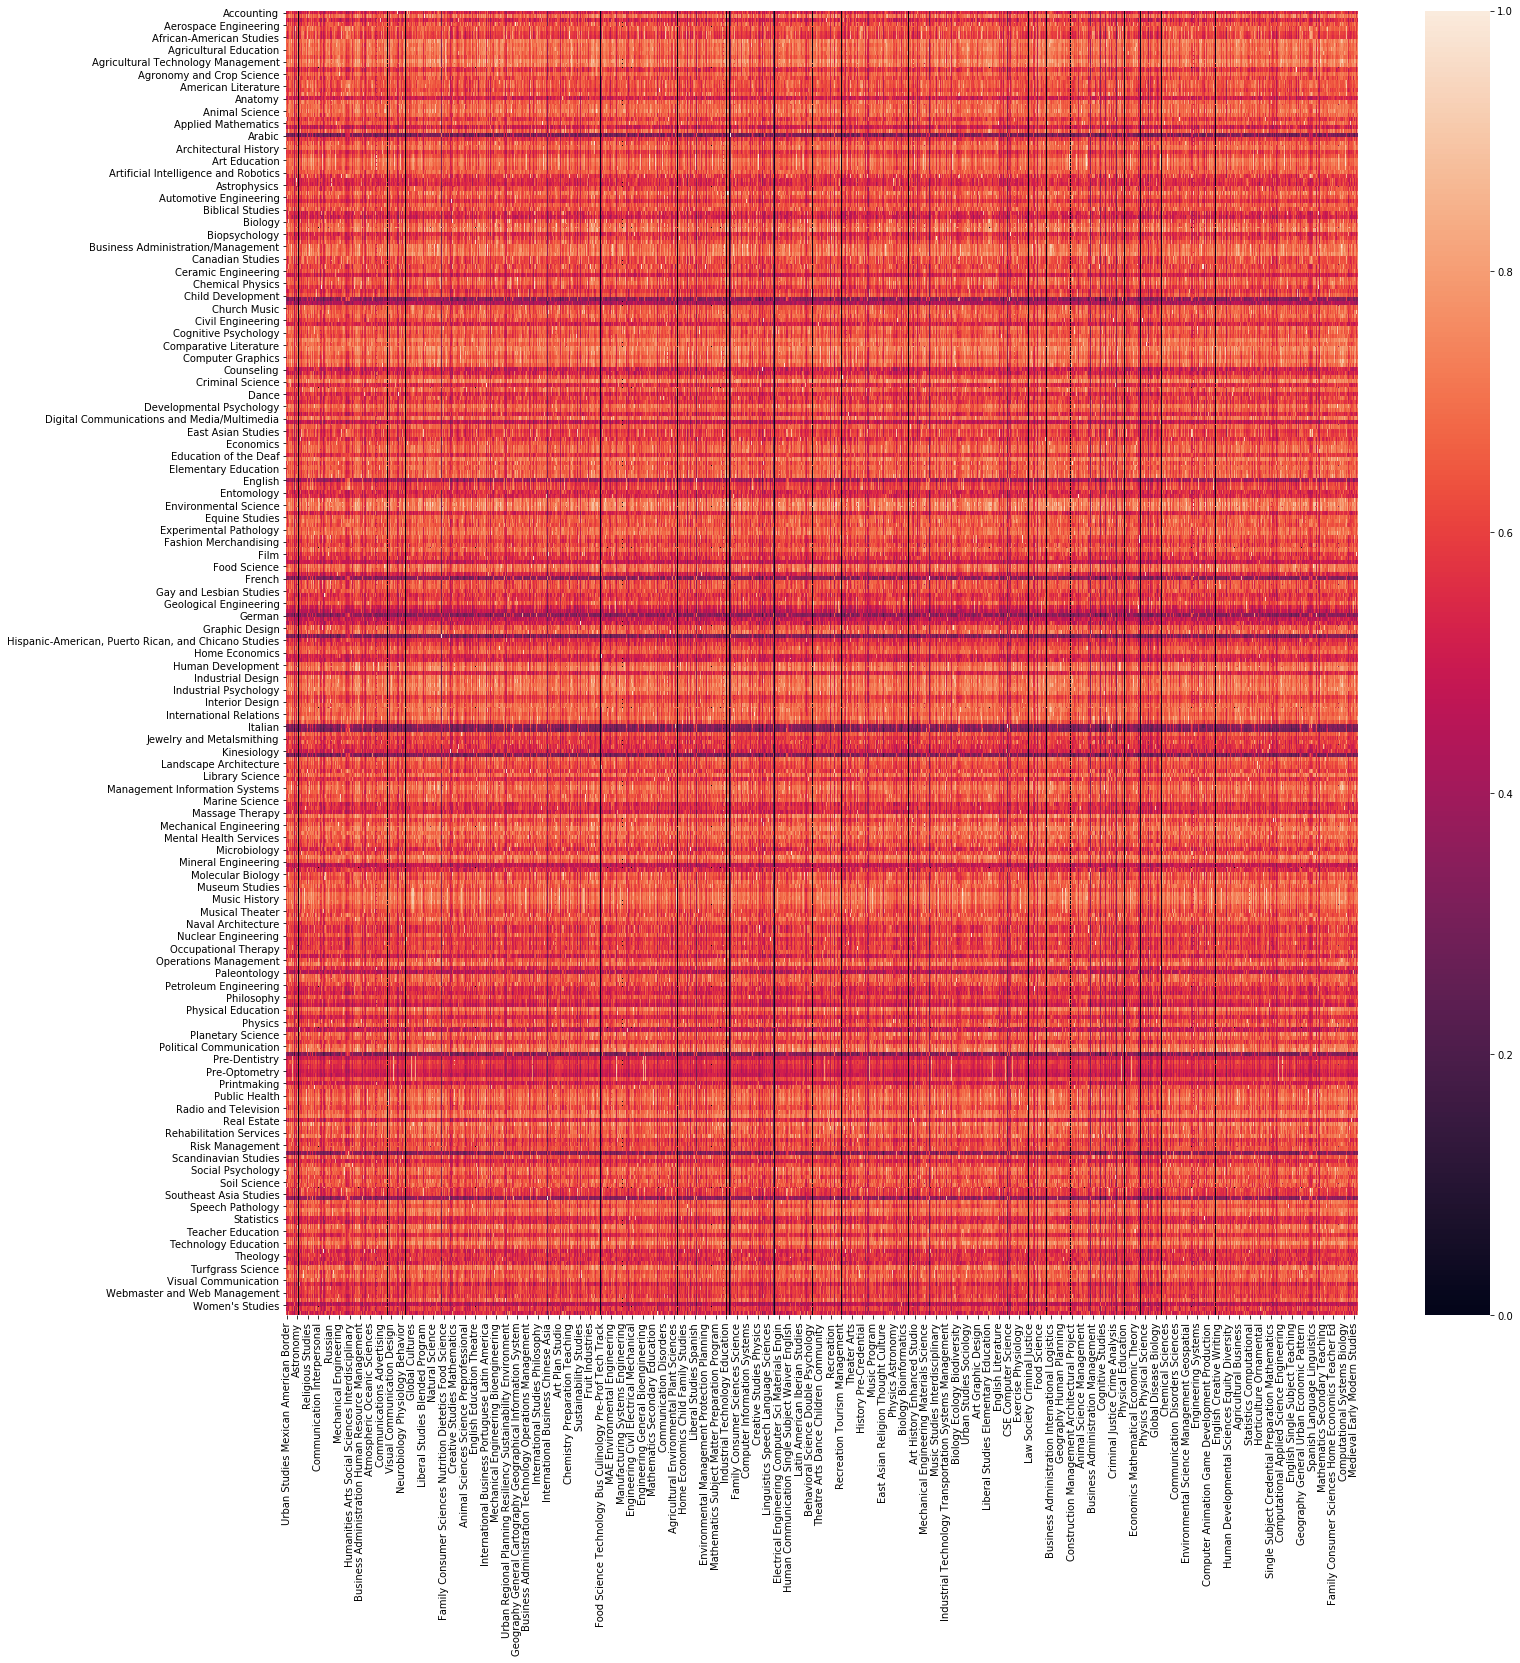

In [229]:
sns.heatmap(df_majors)

In [230]:
df_majors.max(axis=0)

Urban Studies Mexican American Border        0.858978
Anthropology Sociocultural                   0.903325
Engineering Audio                            0.813993
Kinesiology Social Justice                   0.898820
Integrative Biology                          0.927699
                                               ...   
Social Science Environmental Studies         0.928110
Geography Geographic Information Systems     0.882499
Health Sciences Administration Management    0.931723
Film Television                              0.974632
Environmental Studies Biology                0.878490
Length: 2047, dtype: float64

In [15]:
for major in subset[:50]:
    print(major)

Mathematics Computer Science
Physiology Cell Biology
Linguistics Asian Languages Cultures
Mass Communication
Biological Systems Engineering
Humanities Asian Studies
Third World Studies
Genetics Plant Biology
Mechanical Engineering Technology
Liberal Studies Science
Computational Engineering Science
International Business Spanish North America
Criminology
Communications/Entertainment Tourism Communications
Applied Studies
Geosciences Meteorology
Nursing Pre-Licensure
Physiology
English Education (Secondary Teaching Preparation)
Linguistics Specialization Speech Language Sciences
Communication Media Management
Kinesiology
Geography (No Major)
Foods Nutrition
Engineering Technology Education
Journalism Public Relations
Geology Geosciences
Political Science Legal Studies Law Environment
Business Administration Economics
Managerial Economics
Social Sciences Credential
Engineering
Meteorology Climate Science
Nutrition Science
Home Economics Fashion Merchandising
Industrial Technology Packagi

In [53]:
# Source: https://github.com/RaRe-Technologies/gensim-data
import gensim.downloader as api
wiki_2017_model = 'wiki-english-20171001'
text8_model = 'text8'

google_news_model = 'word2vec-google-news-300'
fasttext_model = 'fasttext-wiki-news-subwords-300'

w2v_model = api.load(fasttext_model)

In [ ]:
from symspellpy.symspellpy import SymSpell, Verbosity  # import the module

class AutoCorrector:
    def __init__(
            self,
            initial_capacity = 83000,
            max_edit_distance_dictionary = 2, # maximum edit distance per dictionary precalculation
            prefix_length = 7):
        self.sym_spell = SymSpell(max_edit_distance_dictionary, prefix_length)

        # load dictionary
        dictionary_path = "frequency_dictionary_en_82_765.txt"

        term_index = 0  # column of the term in the dictionary text file
        count_index = 1  # column of the term frequency in the dictionary text file
        if not self.sym_spell.load_dictionary(dictionary_path, term_index, count_index):
            raise Exception('Dictionary file not found')

    def word(self, word):
        max_edit_distance_lookup = 2
        suggestion_verbosity = Verbosity.CLOSEST  # TOP, CLOSEST, ALL
        suggestions = self.sym_spell.lookup(word, suggestion_verbosity,
                                       max_edit_distance_lookup)
        return suggestions[0].term

    def sentence(self, sentence):
        max_edit_distance_lookup = 2
        suggestions = self.sym_spell.lookup_compound(sentence, max_edit_distance_lookup)
        return suggestions[0].term
    
ac = AutoCorrector()

In [68]:
print(dir(w2v_model))

['__class__', '__contains__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_adapt_by_suffix', '_load_specials', '_log_evaluate_word_analogies', '_save_specials', '_smart_save', 'accuracy', 'add', 'closer_than', 'cosine_similarities', 'distance', 'distances', 'doesnt_match', 'evaluate_word_analogies', 'evaluate_word_pairs', 'get_keras_embedding', 'get_vector', 'index2entity', 'index2word', 'init_sims', 'load', 'load_word2vec_format', 'log_accuracy', 'log_evaluate_word_pairs', 'most_similar', 'most_similar_cosmul', 'most_similar_to_given', 'n_similarity', 'rank', 'relative_cosine_similarity', 'save', 'save_word2vec_format', 'similar_by_vector', 'similar_by_word', 'similarity',

In [45]:
def similarity_scorer(seq):
    return textdistance.ratcliff_obershelp.similarity(*seq)

def similarity_scorer2(seq):
    return textdistance.jaro_winkler.similarity(*seq)

def similarity_scorer3(seq):
    seq = [re.sub(r'\W+', ' ', phrase).strip().split() for phrase in seq]
    return w2v_model.n_similarity(*seq)


def create_tasks(majors):
    task_params = []
    for i, first_major in enumerate(majors):
        for j, second_major in enumerate(majors):
            if j < i:
                task_params += [(first_major, second_major)]
    return task_params

def quadratic_form(a, b, c):
    discriminant = b**2 - 4*a*c
    ans1 = (-b + discriminant ** 0.5) / (2 * a)
    ans2 = (-b - discriminant ** 0.5) / (2 * a)
    return (ans1, ans2)

def to_triangular_mat(arr):
    num_lower_indicies = len(arr)
    size = max(*quadratic_form(1, -1, -num_lower_indicies * 2))
    
    if size != int(size):
        raise Exception('Quadratic formula based calculation FAILED!!')
    size = int(size)
    
    mat = np.zeros((size, size))
    lower_indicies = np.tril_indices(size, -1)
    mat[lower_indicies] = arr
    mat = mat + mat.T
    mat[np.diag_indices(size)] = 1.0
    return mat

In [19]:
def save_np_load(filename):
    try:
        return np.load(filename)
    except IOError as ex:
        return None

arr = save_np_load('sequence.npy')
arr2 = save_np_load('edit.npy')
arr3 = save_np_load('w2v.npy')

In [33]:
OVERRIDE_ARR_VALUES = False

In [34]:
if arr is None or OVERRIDE_ARR_VALUES:
    similarity_calculator = ParallelTaskHandler(create_tasks, similarity_scorer, to_triangular_mat)

    print('Expected number of tasks:', (len(subset) ** 2 - len(subset)) // 2)
    start = time.time()
    arr = similarity_calculator.process_items(subset)
    end = time.time()
    print(end - start)
    arr = np.asarray(arr).reshape((len(subset), len(subset)))

In [35]:
if arr2 is None or OVERRIDE_ARR_VALUES:
    similarity_calculator2 = ParallelTaskHandler(create_tasks, similarity_scorer2, to_triangular_mat)

    print('Expected number of tasks:', (len(subset) ** 2 - len(subset)) // 2)
    start = time.time()
    arr2 = similarity_calculator2.process_items(subset)
    end = time.time()
    print(end - start)
    arr2 = np.asarray(arr2).reshape((len(subset), len(subset)))

In [42]:
words = []
for major in subset:
    major = re.sub(r'\W+', ' ', major).strip()
    for word in major.split():
        words += [word]
print('Total number of words:', len(words))
unique_words = list(set(words))
print('Total number of unique words:', len(unique_words))

Total number of words: 7032
Total number of unique words: 845


In [43]:
faulty_words = []
for word in unique_words:
    if w2v_model.vocab.get(word) is None:
        faulty_words += [word]
print('Total number of unique faulty words:', len(faulty_words))

Total number of unique faulty words: 31


In [44]:
pprint(faulty_words)

['NanoEngineering',
 'Prelegal',
 'Resourse',
 'Neuropsych',
 'Bclad',
 'Photocommunication',
 'Prelicensure',
 'Photocommunications',
 'BioResource',
 'Culinology',
 'Geohydrology',
 'FinanceManagement',
 'Engergy',
 'Multiculutral',
 'Concentratration',
 'Managementmt',
 'Studes',
 'Aspcts',
 'Technocultural',
 'Icam',
 'Espm',
 'Physicial',
 'Bioeducation',
 'SustaInable',
 'Concetration',
 'Explor',
 'Postlicensure',
 'Prephysical',
 'Kinesiotherapy',
 'Concentratio',
 'FIne']


In [58]:
def has_faulty_words(major):
    for word in faulty_words:
        if word in major:
            return True
    return False

sub_subset = [major for major in subset if not has_faulty_words(major)]

In [67]:
if arr3 is None or OVERRIDE_ARR_VALUES:
    similarity_calculator3 = ParallelTaskHandler(create_tasks, similarity_scorer3, to_triangular_mat)

    print('Expected number of tasks:', (len(subset) ** 2 - len(subset)) // 2)
    start = time.time()
    arr3 = similarity_calculator3.process_items(sub_subset)
    end = time.time()
    print(end - start)
    arr3 = np.asarray(arr3).reshape((len(sub_subset), len(sub_subset)))

In [61]:
np.save('sequence.npy', arr)
np.save('edit.npy', arr2)
np.save('w2v.npy', arr3)

## Visualizing similarities

In [62]:
MAX_DISPLAY = 100
SHOW_ANNOT = False
MIN_SIM_SCORE = 0.8
DISPLAY_OPTS = {
    'left': 0.25,
    'right': 0.9,
    'top': 1.0,
    'bottom': 0.25,
}

In [63]:
def visualize_similarity_matrix(mat, show_annotations=False, display_opts={}):
    print('Size of dataframe: ', mat.shape)
    
    labels = subset if show_annotations else None
    df = pd.DataFrame(mat, columns=labels, index=labels)
    
    sns.heatmap(df, annot=show_annotations, fmt='.1f')
    plt.subplots_adjust(**display_opts)

In [64]:
def filter_and_show_results(mat, min_score, max_display):
    y_coords, x_coords = np.nonzero( (mat > min_score) & (mat != 1.0) )
    print('Number of matches:', len(x_coords) // 2)
    y_coords = y_coords[:max_display]
    x_coords = x_coords[:max_display]
    for y, x in zip(y_coords, x_coords):
        print(subset[x])
        print(subset[y])
        print(mat[y, x])
        print()

In [ ]:
visualize_similarity_matrix(arr, SHOW_ANNOT, DISPLAY_OPTS)

In [ ]:
filter_and_show_results(arr, MIN_SIM_SCORE, MAX_DISPLAY)

In [ ]:
visualize_similarity_matrix(arr2, SHOW_ANNOT, DISPLAY_OPTS)

In [ ]:
filter_and_show_results(arr2, MIN_SIM_SCORE, MAX_DISPLAY)

Size of dataframe:  (2070, 2070)


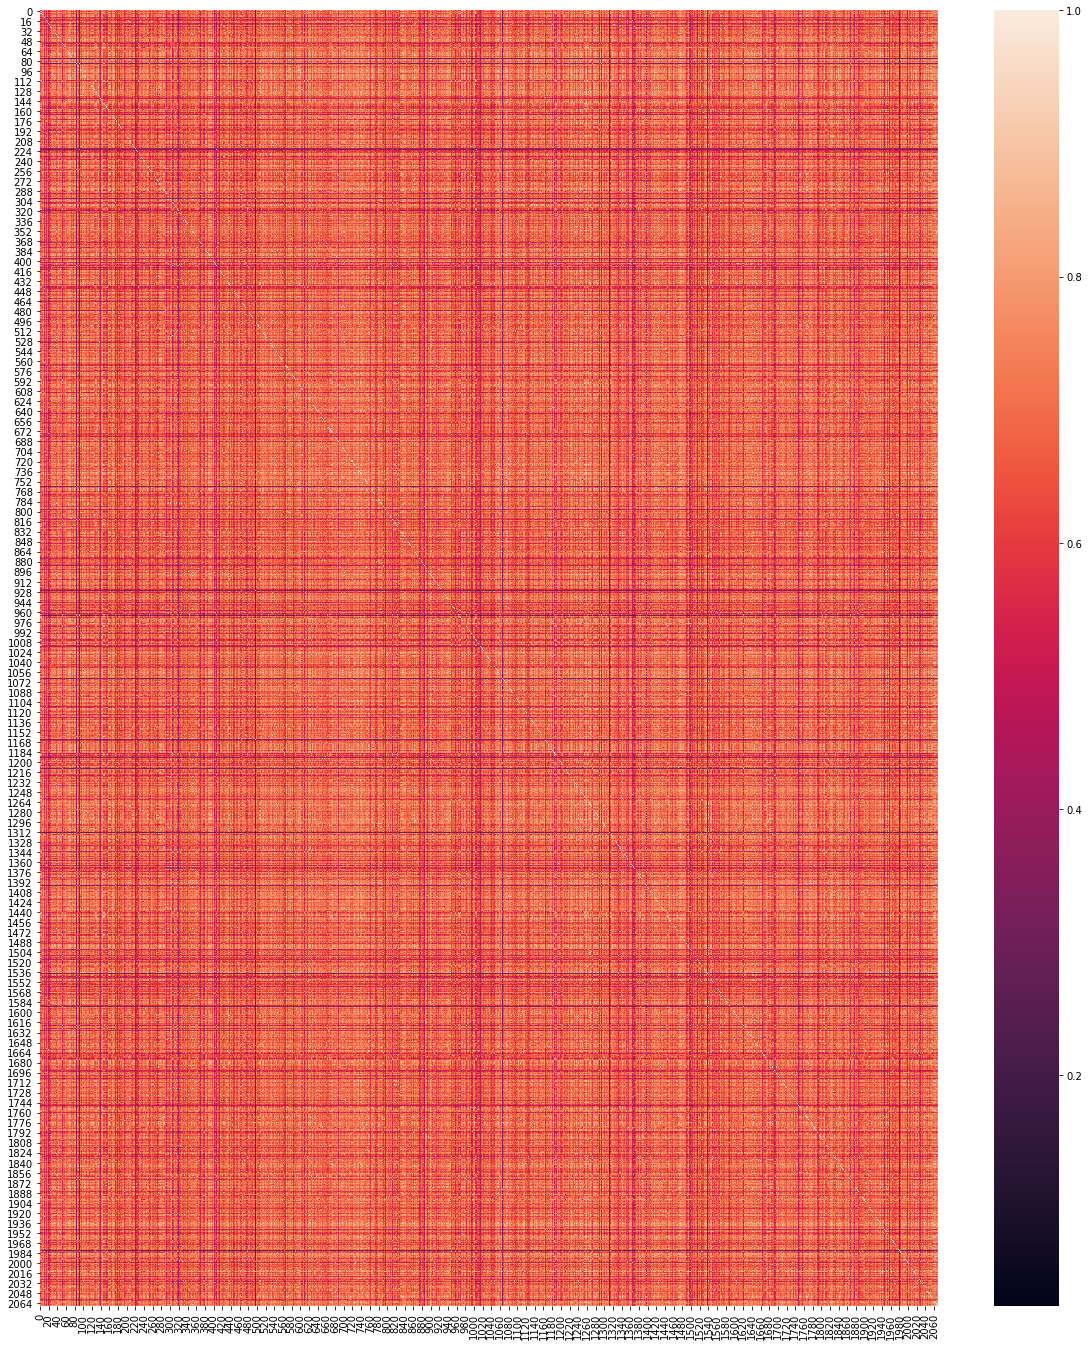

In [65]:
visualize_similarity_matrix(arr3, SHOW_ANNOT, DISPLAY_OPTS)

In [66]:
filter_and_show_results(arr3, MIN_SIM_SCORE, MAX_DISPLAY)

Number of matches: 185149
Biological Systems Engineering
Mathematics Computer Science
0.8089979887008667

Mechanical Engineering Technology
Mathematics Computer Science
0.8176308870315552

Liberal Studies Science
Mathematics Computer Science
0.8262324333190918

Computational Engineering Science
Mathematics Computer Science
0.9284970164299011

Engineering Technology Education
Mathematics Computer Science
0.8480751514434814

Meteorology Climate Science
Mathematics Computer Science
0.8402209281921387

Nutrition Science
Mathematics Computer Science
0.8650271892547607

Chemistry (Applied Forensic Chemistry)
Mathematics Computer Science
0.8151452541351318

Economics Mathematical
Mathematics Computer Science
0.8228933811187744

Computer Science Systems
Mathematics Computer Science
0.9420320391654968

Family Consumer Sciences Nutrition Dietetics Food Science
Mathematics Computer Science
0.8187310099601746

Landscape Irrigation Science
Mathematics Computer Science
0.8176071047782898

Informatio

In [ ]:
arr4 = arr * arr2
visualize_similarity_matrix(arr4, SHOW_ANNOT, DISPLAY_OPTS)

In [ ]:
filter_and_show_results(arr4, MIN_SIM_SCORE, MAX_DISPLAY)

In [ ]:
arr5 = arr * 0.5 + arr2 * 0.5
visualize_similarity_matrix(arr5, SHOW_ANNOT, DISPLAY_OPTS)

In [ ]:
filter_and_show_results(arr5, MIN_SIM_SCORE, MAX_DISPLAY)

## Debug Memory Usage

In [ ]:
import sys

top_n_vars = 10

# Source: https://stackoverflow.com/a/51046503
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

# NOTE: Do not put this in a function, since locals() will pull all variables w.r.t. the context for which it was called
for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()), key=lambda x: -x[1])[:top_n_vars]:
    print("{:>30}: {:>10}".format(name, sizeof_fmt(size)))

In [ ]:
import gc
gc.collect()

In [ ]:
wv.n_similarity('mechatronics engineering'.split(), 'graphic design'.split())

## K-Means clustering

In [ ]:
# import collections
# from nltk import word_tokenize
# from nltk.corpus import stopwords
# from nltk.stem import PorterStemmer
# from sklearn.cluster import KMeans
# from sklearn.feature_extraction.text import TfidfVectorizer
# from pprint import pprint


# def word_tokenizer(text):
#     #tokenizes and stems the text
#     tokens = word_tokenize(text)
# #     stemmer = PorterStemmer()
# #     tokens = [stemmer.stem(t) for t in tokens if t not in stopwords.words('english')]
#     return tokens


# def cluster_sentences(sentences, nb_of_clusters=5):
#     tfidf_vectorizer = TfidfVectorizer(
#                                     ngram_range=(1,3),
#                                     tokenizer=word_tokenizer,
#                                     stop_words=stopwords.words('english'),
#                                     max_df=1.0,
#                                     min_df=0,
#                                     lowercase=True)
#     #builds a tf-idf matrix for the sentences
#     tfidf_matrix = tfidf_vectorizer.fit_transform(sentences)
#     print(tfidf_matrix.shape)
#     print(arr3.shape)
#     kmeans = KMeans(n_clusters=nb_of_clusters)
#     kmeans.fit(tfidf_matrix)
#     clusters = collections.defaultdict(list)
#     for i, label in enumerate(kmeans.labels_):
#         clusters[label].append(i)
#     return dict(clusters)



# sentences = subset
# nclusters = 200
# clusters = cluster_sentences(sentences, nclusters)
# print(len(clusters))
# for cluster in range(nclusters):
#     print("cluster", cluster, ":")
#     for i, sentence in enumerate(clusters[cluster]):
#         print("\tmajor", i, ":",sentences[sentence])

In [ ]:
# def seq_distance(*seq):
#     return textdistance.ratcliff_obershelp.distance(*seq)

# def ordered_edit_distance(*seq):
#     return textdistance.jaro_winkler.distance(*seq)

# def final_distance(*seq):
#     return seq_distance(*seq) * ordered_edit_distance(*seq)


# import sklearn.cluster
# affprop = sklearn.cluster.AffinityPropagation(affinity="precomputed", damping=0.5)
# affprop.fit(arr3)
# np_subset = np.array(subset)
# # print(affprop.labels_)
# # print(affprop.cluster_centers_indices_)
# print(len(np.unique(affprop.labels_)))
# for cluster_id in np.unique(affprop.labels_):
#     example = np_subset[affprop.cluster_centers_indices_[cluster_id]]
#     cluster = np.unique(np_subset[np.nonzero(affprop.labels_ == cluster_id)[0]])
#     cluster_str = ", ".join(cluster)
#     print(" - *%s:* %s" % (example, cluster_str))
#     print('\n\n')

# # from nltk.cluster import KMeansClusterer
# # import nltk
# # NUM_CLUSTERS=200
# # kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=final_distance, repeats=25)
# # assigned_clusters = kclusterer.cluster(subset, assign_clusters=True)
# # print (assigned_clusters)